In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


# Data Prep

loading csv files from google drive

In [2]:
directory = '/content/drive/My Drive/NBA Season Data/2017-18'
files = {}
for filename in os.listdir(directory):
  stat,_ = filename.split('.')
  files[stat] = pd.read_csv(os.path.join(directory, filename))
  files[stat].columns = files[stat].columns.str.strip()

In [3]:
files.keys()

dict_keys(['box_scores', 'post_up', 'assists', 'putback', 'screen_assists', 'hand_off', 'pnr_handler', 'drives', 'off_screen', 'cut', 'shot_chart', 'isolation', 'pnr_man', 'spot_up', 'height_weight', 'touches', 'catch_and_shoot'])

In [4]:
for name in files.keys():
  print(f"STAT: {name}")
  files[name].info()
  print()

STAT: box_scores
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PLAYER  540 non-null    object 
 1   TEAM    540 non-null    object 
 2   MIN     540 non-null    float64
 3   FGA     540 non-null    float64
 4   3PA     540 non-null    float64
 5   AST     540 non-null    float64
dtypes: float64(4), object(2)
memory usage: 25.4+ KB

STAT: post_up
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PLAYER    540 non-null    object 
 1   TEAM      540 non-null    object 
 2   POST UPS  540 non-null    float64
dtypes: float64(1), object(2)
memory usage: 12.8+ KB

STAT: assists
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
--

merging dataframes

In [5]:
players = pd.DataFrame()
for stat in files.keys():
  if players.empty:
    players = files[stat]
  else:
    players = pd.merge(players, files[stat], how="left", on = ["PLAYER", "TEAM"])

players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PLAYER               540 non-null    object 
 1   TEAM                 540 non-null    object 
 2   MIN                  540 non-null    float64
 3   FGA                  540 non-null    float64
 4   3PA                  540 non-null    float64
 5   AST                  540 non-null    float64
 6   POST UPS             540 non-null    float64
 7   PASSES MADE          540 non-null    float64
 8   PUTBACK FREQ         259 non-null    float64
 9   SCREEN ASSISTS       540 non-null    float64
 10  HANDOFF FREQ         236 non-null    float64
 11  PNR HANDLER FREQ     277 non-null    float64
 12  DRIVES               540 non-null    float64
 13  PASS OFF DRIVE       540 non-null    float64
 14  OFF SCREEN FREQ      230 non-null    float64
 15  CUT FREQ             312 non-null    flo

In [6]:
directory = '/content/drive/My Drive/NBA Season Data/2017-18'
files = {}
for filename in os.listdir(directory):
  stat,_ = filename.split('.')
  files[stat] = pd.read_csv(os.path.join(directory, filename))
  files[stat].columns = files[stat].columns.str.strip()

players17_18 = pd.DataFrame()
for stat in files.keys():
  if players17_18.empty:
    players17_18 = files[stat]
  else:
    players17_18 = pd.merge(players17_18, files[stat], how="left", on = ["PLAYER", "TEAM"])

players17_18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PLAYER               540 non-null    object 
 1   TEAM                 540 non-null    object 
 2   MIN                  540 non-null    float64
 3   FGA                  540 non-null    float64
 4   3PA                  540 non-null    float64
 5   AST                  540 non-null    float64
 6   POST UPS             540 non-null    float64
 7   PASSES MADE          540 non-null    float64
 8   PUTBACK FREQ         259 non-null    float64
 9   SCREEN ASSISTS       540 non-null    float64
 10  HANDOFF FREQ         236 non-null    float64
 11  PNR HANDLER FREQ     277 non-null    float64
 12  DRIVES               540 non-null    float64
 13  PASS OFF DRIVE       540 non-null    float64
 14  OFF SCREEN FREQ      230 non-null    float64
 15  CUT FREQ             312 non-null    flo

In [20]:
from sklearn.base import TransformerMixin, ClusterMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

class CleanDataset(TransformerMixin):

  def fit(self, X, y=None):
    return self

  def height_to_inches(self, height):
    ft, inches = height.split('-')
    return int(ft) * 12 + int(inches)

  def transform(self, X, y=None):
    # fill NULL stats
    X.fillna(0, inplace=True)

    # filter out players with less than 15 minutes
    X = X.loc[X['MIN'] >= 15,]

    # convert height
    X['HEIGHT'] = X['HEIGHT'].apply(self.height_to_inches)

    #convert all columns to numeric
    numeric_columns = X.columns.difference(['PLAYER', 'TEAM'])
    X[numeric_columns] = X[numeric_columns].apply(pd.to_numeric, errors='coerce')
    X.fillna(0, inplace=True)

    return X

class NormalizeDataset(TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):

    # Normalize 'SCREEN ASSISTS'
    X.loc[X['AST'] != 0, 'SCREEN ASSISTS'] = X.loc[X['AST'] != 0, 'SCREEN ASSISTS'] / X['AST']

    # Normalize 'PASS OFF DRIVE' when 'DRIVES' is not 0
    X.loc[X['DRIVES'] != 0, 'PASS OFF DRIVE'] = X.loc[X['DRIVES'] != 0, 'PASS OFF DRIVE'] / X.loc[X['DRIVES'] != 0, 'DRIVES']

    # Normalize columns in cols_norm_touches
    cols_norm_touches = ['AST', 'PASSES MADE', 'DRIVES', 'FRONT CT TOUCHES', 'ELBOW TOUCHES', 'PAINT TOUCHES']
    for stat in cols_norm_touches:
        X.loc[:, stat] = (X[stat] / X['TOUCHES']) * 100

    # Rename columns related to touches
    X.rename(columns={'AST': 'AST PER TOUCHES', 'PASSES MADE': 'PASSES PER TOUCHES', 'DRIVES': 'DRIVES PER TOUCHES', 'FRONT CT TOUCHES': 'FRONT CT TOUCH FREQ', 'PAINT TOUCHES':'PAINT TOUCHES FREQ', 'ELBOW TOUCHES':'ELBOW TOUCH FREQ'}, inplace=True)

    # Normalize 'CATCH AND SHOOT 3 FREQ' and 'CORNER 3 FREQ'
    cols_norm_3pa = ['CATCH AND SHOOT 3PA', 'CORNER 3 FGA']
    X['CATCH AND SHOOT 3 FREQ'] = 100 * X['CATCH AND SHOOT 3PA'] / np.where(X['3PA'] != 0, X['3PA'], 1)
    X['CORNER 3 FREQ'] = 100 * X['CORNER 3 FGA'] / np.where(X['3PA'] != 0, X['3PA'], 1)

    # Normalize columns in cols_norm_fga
    cols_norm_fga = ['CATCH AND SHOOT FGA', 'IN THE PAIT FGA', 'MID RANGE FGA', 'CATCH AND SHOOT 3PA', 'CORNER 3 FGA', 'POST UPS']
    for stat in cols_norm_fga:
        X.loc[:, stat] = 100 * X[stat] / X['FGA']

    # Rename columns related to FGA
    X.rename(columns={'CATCH AND SHOOT FGA': 'CATCH AND SHOOT FREQ', 'IN THE PAIT FGA': 'IN THE PAIT FREQ', 'MID RANGE FGA': 'MID RANGE FREQ', 'CATCH AND SHOOT 3PA': 'CATCH AND SHOOT 3 TFREQ', 'CORNER 3 FGA': 'CORNER 3 TFREQ', 'POST UPS': 'POST UPS FREQ'}, inplace=True)

    # Drop unnecessary columns
    X.drop(['MIN', 'FGA', '3PA', 'TOUCHES'], axis=1, inplace=True)

    X.reset_index(inplace=True)
    X.drop('index', axis=1, inplace=True)

    # return numerical portion for scaler (preprocessed dataset will be preserved bc drop creates new df)
    return X

class Cluster(ClusterMixin):
  def __init__(self, kmeans = None, num_clusters = 8) -> None:
    self.kmeans = kmeans
    self.num_clusters = num_clusters

  def fit(self, X, y=None):
    if not self.kmeans:
      print("should fire twice")
      self.kmeans = KMeans(n_clusters=self.num_clusters)
      self.kmeans.fit(X)
    return self

  def transform(self, X, y=None):

    newX = pd.DataFrame()
    # get cluster labels
    print("something")
    newX['CLUSTER'] = self.kmeans.predict(X)

    # get soft cluster distances
    col_names =[f'CLUSTER {i} DISTANCE' for i in range(self.num_clusters)]
    newX.loc[:, col_names] = self.kmeans.transform(X)

    # get silhouette scores
    silhouette_coeffs = silhouette_samples(X, self.kmeans.labels_)
    newX.loc[:,'SILHOUETTE COEFFICIENT'] = silhouette_coeffs

    return newX

cluster_pipeline = Pipeline([('std_scaler', StandardScaler()),
                            ('cluster', Cluster(None, num_clusters=8))])

preprocess_pipeline = Pipeline([('clean', CleanDataset()),
                                ('normalize', NormalizeDataset())])



In [12]:
# players_clean = preprocess_pipeline.fit_transform(players)
# # players_clean.info()
# clusters = cluster_pipeline.fit_transform(players_clean.drop(['PLAYER', 'TEAM', 'PASSES PER TOUCHES'], axis=1))
# result = pd.concat([players_clean, clusters], axis=1)


players17_18_clean = preprocess_pipeline.fit_transform(players17_18)
cluster17_18 = cluster_pipeline.fit_transform(players17_18_clean.drop(['PLAYER', 'TEAM', 'PASSES PER TOUCHES'], axis=1))
result17_18 = pd.concat([players17_18_clean, cluster17_18], axis=1)
result17_18

<ipython-input-11-b6561dbaa75b>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['HEIGHT'] = X['HEIGHT'].apply(self.height_to_inches)
<ipython-input-11-b6561dbaa75b>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numeric_columns] = X[numeric_columns].apply(pd.to_numeric, errors='coerce')
<ipython-input-11-b6561dbaa75b>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

should fire twice
something


,PLAYER,TEAM,AST PER TOUCHES,POST UPS FREQ,PASSES PER TOUCHES,PUTBACK FREQ,SCREEN ASSISTS,HANDOFF FREQ,PNR HANDLER FREQ,DRIVES PER TOUCHES,...,CLUSTER,CLUSTER 0 DISTANCE,CLUSTER 1 DISTANCE,CLUSTER 2 DISTANCE,CLUSTER 3 DISTANCE,CLUSTER 4 DISTANCE,CLUSTER 5 DISTANCE,CLUSTER 6 DISTANCE,CLUSTER 7 DISTANCE,SILHOUETTE COEFFICIENT
0,James Harden,HOU,10.551559,6.965174,61.390887,0.7,0.034091,3.2,35.8,20.503597,...,6,8.827553,10.375908,13.999888,12.767507,12.381317,13.721390,6.140781,11.752755,0.250023
1,Anthony Davis,NOP,3.207810,32.820513,62.343096,7.4,1.695652,1.5,1.4,5.718271,...,7,8.676761,6.822505,5.644977,7.378507,8.670461,5.563986,8.401261,3.342106,0.244279
2,LeBron James,CLE,10.447761,22.797927,65.442021,3.0,0.109890,1.1,20.9,13.432836,...,6,7.772330,8.287038,10.619891,10.483806,10.619443,10.612212,5.483541,8.295041,0.226881
3,Damian Lillard,POR,8.029197,0.000000,65.936740,1.5,0.030303,7.0,47.4,15.328467,...,6,5.844231,7.818077,12.383890,10.450103,9.568711,11.718574,3.341497,9.968239,0.287285
4,Giannis Antetokounmpo,MIL,5.600933,20.855615,66.977830,6.0,0.291667,1.9,11.3,12.835473,...,7,6.930683,6.501706,7.997081,8.344086,8.996113,7.751793,5.881841,5.527630,0.007004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,Alex Caruso,LAL,6.779661,0.000000,81.694915,0.0,0.050000,0.0,30.2,8.813559,...,0,2.498839,4.542211,9.339172,6.325832,6.630995,7.750143,4.897314,7.201878,0.264952
343,Jason Terry,MIL,6.417112,0.000000,79.679144,0.0,0.166667,7.7,0.0,4.812834,...,4,8.457073,6.989190,13.108899,5.840621,5.241372,9.674782,10.274627,10.322168,0.068524
344,Kyle Collinsworth,DAL,7.500000,16.129032,79.166667,11.4,0.111111,0.0,25.7,17.916667,...,0,5.136569,5.390628,9.245592,7.009884,7.707151,7.557920,6.769942,6.883306,0.025916
345,Semi Ojeleye,BOS,1.477833,3.846154,82.758621,0.0,0.666667,4.8,0.0,3.448276,...,3,8.594539,6.613309,11.212620,4.000090,5.692684,7.621615,10.425323,8.776984,0.195300


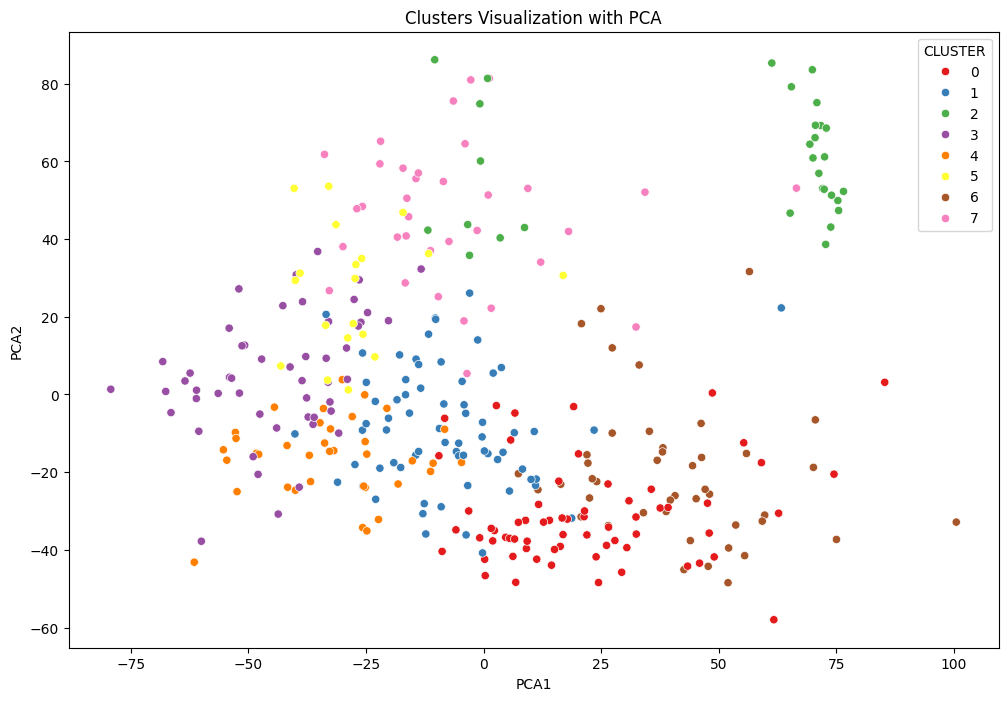

In [21]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming result17_18 is your final DataFrame with clustering results
# Perform PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(result17_18.drop(['PLAYER', 'TEAM', 'CLUSTER'], axis=1))

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['CLUSTER'] = result17_18['CLUSTER']

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='CLUSTER', palette='Set1', data=pca_df, legend='full')
plt.title('Clusters Visualization with PCA')
plt.show()

In [13]:
# clusters.loc[:,['PLAYER', 'SILHOUETTE COEFFICIENT'] + col_names].sort_values(by=['SILHOUETTE COEFFICIENT'],ascending=False)

In [27]:
for i in range(8):
  print(f"CLUSTER {i}")
  print(result17_18.loc[result17_18['CLUSTER'] == i, 'PLAYER'])
  print()

CLUSTER 0
89         Jordan Clarkson
101            Ricky Rubio
102        Malcolm Brogdon
108             Trey Burke
113          Elfrid Payton
              ...         
327          Iman Shumpert
331    Matthew Dellavedova
341         Marquis Teague
342            Alex Caruso
344      Kyle Collinsworth
Name: PLAYER, Length: 65, dtype: object

CLUSTER 1
20             Paul George
25         Khris Middleton
33         Harrison Barnes
35           Tobias Harris
37             Eric Gordon
              ...         
316          Royce O'Neale
323          Jaylen Morris
336          Patrick McCaw
339    Sindarius Thornwell
340             Wes Iwundu
Name: PLAYER, Length: 67, dtype: object

CLUSTER 2
69        Andre Drummond
83          Enes Freedom
84      Hassan Whiteside
88          Steven Adams
90          Clint Capela
92           Rudy Gobert
112    Jonas Valanciunas
127       DeAndre Jordan
131          Robin Lopez
151     Montrezl Harrell
162          Greg Monroe
194          John H

In [ ]:
cols = [f'CLUSTER {i} DISTANCE' for i in range(8)]
cols = ['PLAYER', 'CLUSTER', 'SILHOUETTE COEFFICIENT'] + cols
result17_18.loc[:, cols]

,PLAYER,CLUSTER,SILHOUETTE COEFFICIENT,CLUSTER 0 DISTANCE,CLUSTER 1 DISTANCE,CLUSTER 2 DISTANCE,CLUSTER 3 DISTANCE,CLUSTER 4 DISTANCE,CLUSTER 5 DISTANCE,CLUSTER 6 DISTANCE,CLUSTER 7 DISTANCE
0,Aaron Gordon,2,0.014880,3.265769,5.111733,2.504274,3.803850,7.265770,5.904709,4.890954,3.658130
1,Al Horford,3,0.301873,6.291893,5.590068,5.541167,2.732572,7.548201,8.202796,6.968991,5.421791
2,Al-Farouq Aminu,7,0.300008,4.365347,6.126000,5.128297,5.301972,8.700959,7.241339,4.818260,1.937464
3,Alan Williams,4,0.299468,11.113824,6.109186,9.669434,7.608717,3.350551,11.860993,11.902824,9.986391
4,Alec Burks,2,-0.065526,2.867617,6.901382,2.572983,5.798706,8.908344,4.803276,5.192042,4.796224
...,...,...,...,...,...,...,...,...,...,...,...
325,Wilson Chandler,2,0.031028,3.167746,5.876798,2.326750,3.974423,7.902500,5.591371,5.037062,3.966193
326,Yogi Ferrell,5,0.353276,5.257554,9.981207,5.745473,8.671320,11.431688,2.370855,7.948207,8.081787
327,Zach LaVine,0,0.204366,3.562886,8.815746,4.645512,7.425516,10.468189,5.640064,5.153348,6.560295
328,Zach Randolph,3,0.271617,7.913206,4.883514,5.738815,3.054009,5.867054,9.051016,9.064722,7.187671


# 2015-2016 Season Clusters

In [ ]:
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)  # Display full width

for i in range(8):
  print(f"CLUSTER {i}")
  print(result17_18.loc[result17_18['CLUSTER'] == i, 'PLAYER'])
  print()

CLUSTER 0
20                Arron Afflalo
22                Avery Bradley
29                 Bradley Beal
36                  Buddy Hield
37                  C.J. Watson
40                 Caris LeVert
42             Chandler Parsons
49                 Courtney Lee
54             Danilo Gallinari
57                   Dante Exum
76                 Devin Harris
87                E'Twaun Moore
93                  Eric Gordon
95                Evan Fournier
98               Garrett Temple
99                  Gary Harris
103            Gerald Henderson
114               Iman Shumpert
115               Isaiah Canaan
128                Jamal Murray
142                Jerian Grant
148                  Joe Ingles
158             Jordan Crawford
159               Jordan Farmar
162             Josh Richardson
176               Kent Bazemore
177    Kentavious Caldwell-Pope
192           Langston Galloway
202               Manu Ginobili
207                Marcus Smart
208             Marcus Thornto